# Figure: AMR Orthologs are common
 - Abundance of Major AMR Classes
 - AMR richness distribution by City
 - AMR read-fraction distribution by City


In [1]:
%load_ext rpy2.ipython

import pandas as pd
from metasub_utils.packet_parse import MetaSUBTableFactory
from capalyzer.packet_parser.experimental import umap
import warnings
from os.path import isfile

warnings.filterwarnings('ignore')

core_tabler = MetaSUBTableFactory.core_factory()

/home/dcdanko/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
sum(pd.read_csv('/home/dcdanko/Dropbox/resources_and_shared/release_packet_jun12_2019/antimicrobial_resistance/megares_amr_class_rpkm.csv', index_col=0).sum(axis=1) > 0)

2251

In [4]:
%%R

library(ggthemes)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(ALDEx2)
library(RColorBrewer)

## AMR richness distribution by City


In [7]:

richness = core_tabler.amr_alpha_diversity(kind='gene', metric='richness', remove_zero_rows=False, count=True)
richness_city = pd.concat([core_tabler.metadata['city'], core_tabler.metadata['continent'], richness], axis=1)
richness_city.columns = ['city', 'continent', 'richness']
richness_city['continent'] = [str(el) for el in richness_city['continent']]
richness_city = richness_city[richness_city['richness'].notna()]
city_median = richness_city.groupby(by='city').mean()['richness']
city_order = list(city_median.sort_values(ascending=False).index)
cities = richness_city['city'].value_counts()
richness_city = richness_city.loc[richness_city['city'].isin(cities[cities > 3].index)]

richness_city = richness_city.groupby('city').filter(lambda tbl: sum(tbl['richness'] > 0) >= 3)

richness_city.head()

,city,continent,richness
haib17CEM4890_H2NYMCCXY_SL254769,offa,sub_saharan_africa,97.0
haib17CEM4890_H2NYMCCXY_SL254770,offa,sub_saharan_africa,264.0
haib17CEM4890_H2NYMCCXY_SL254771,offa,sub_saharan_africa,238.0
haib17CEM4890_H2NYMCCXY_SL254772,offa,sub_saharan_africa,97.0
haib17CEM4890_H2NYMCCXY_SL254773,new_york_city,north_america,33.0


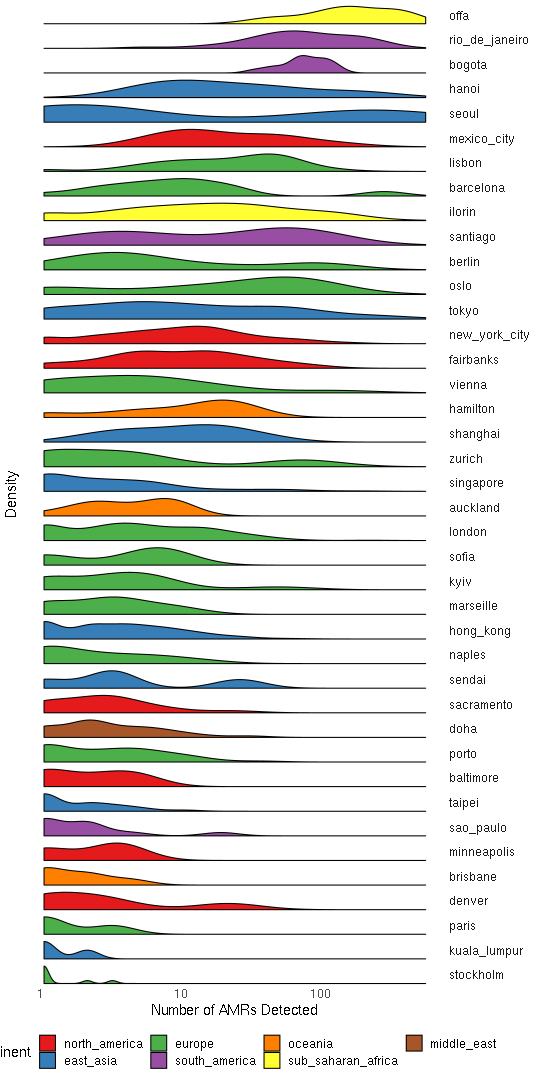

In [8]:
%%R -i richness_city -i city_median -i city_order --height 1080 --width 540


richness_city$city = ordered(richness_city$city, levels=city_order)
richness_city$continent = ordered(
    richness_city$continent,
    levels=c(
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
)
)
ggplot(richness_city, aes(x=richness, fill=continent)) +
    geom_density(size=0.5) +
    facet_grid(city~., scales="free_y") +
    theme_minimal() +
    ylab('Density') +
    xlab('Number of AMRs Detected') +
    scale_x_log10() +
    scale_fill_brewer(palette = "Set1") +
    labs(color="") +
    theme(
        axis.text.x= element_text(angle=0, hjust=1),
        axis.text.y= element_blank(),
        strip.text.y= element_text(angle=0, hjust=0),
        text = element_text(size=15),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='bottom'
    )

## Abundance of Major AMR Classes

In [29]:
def zero_drop_median(vals):
    vals = vals[vals > 0]
    return vals.median()

amr_classes = core_tabler.amrs()
print(amr_classes.shape)
amr_classes = amr_classes.drop(columns='Elfamycins')
amr_order = list(amr_classes.apply(zero_drop_median).sort_values(ascending=False).index)
amr_count = pd.DataFrame((amr_classes > 0).mean())
amr_count['kind'] = amr_count.index
amr_count.columns = ['prevalence', 'kind']
amr_classes = amr_classes.melt()
amr_classes.head()

(2122, 21)


,variable,value
0,Aminocoumarins,0.0
1,Aminocoumarins,0.0
2,Aminocoumarins,0.0
3,Aminocoumarins,0.0
4,Aminocoumarins,0.0


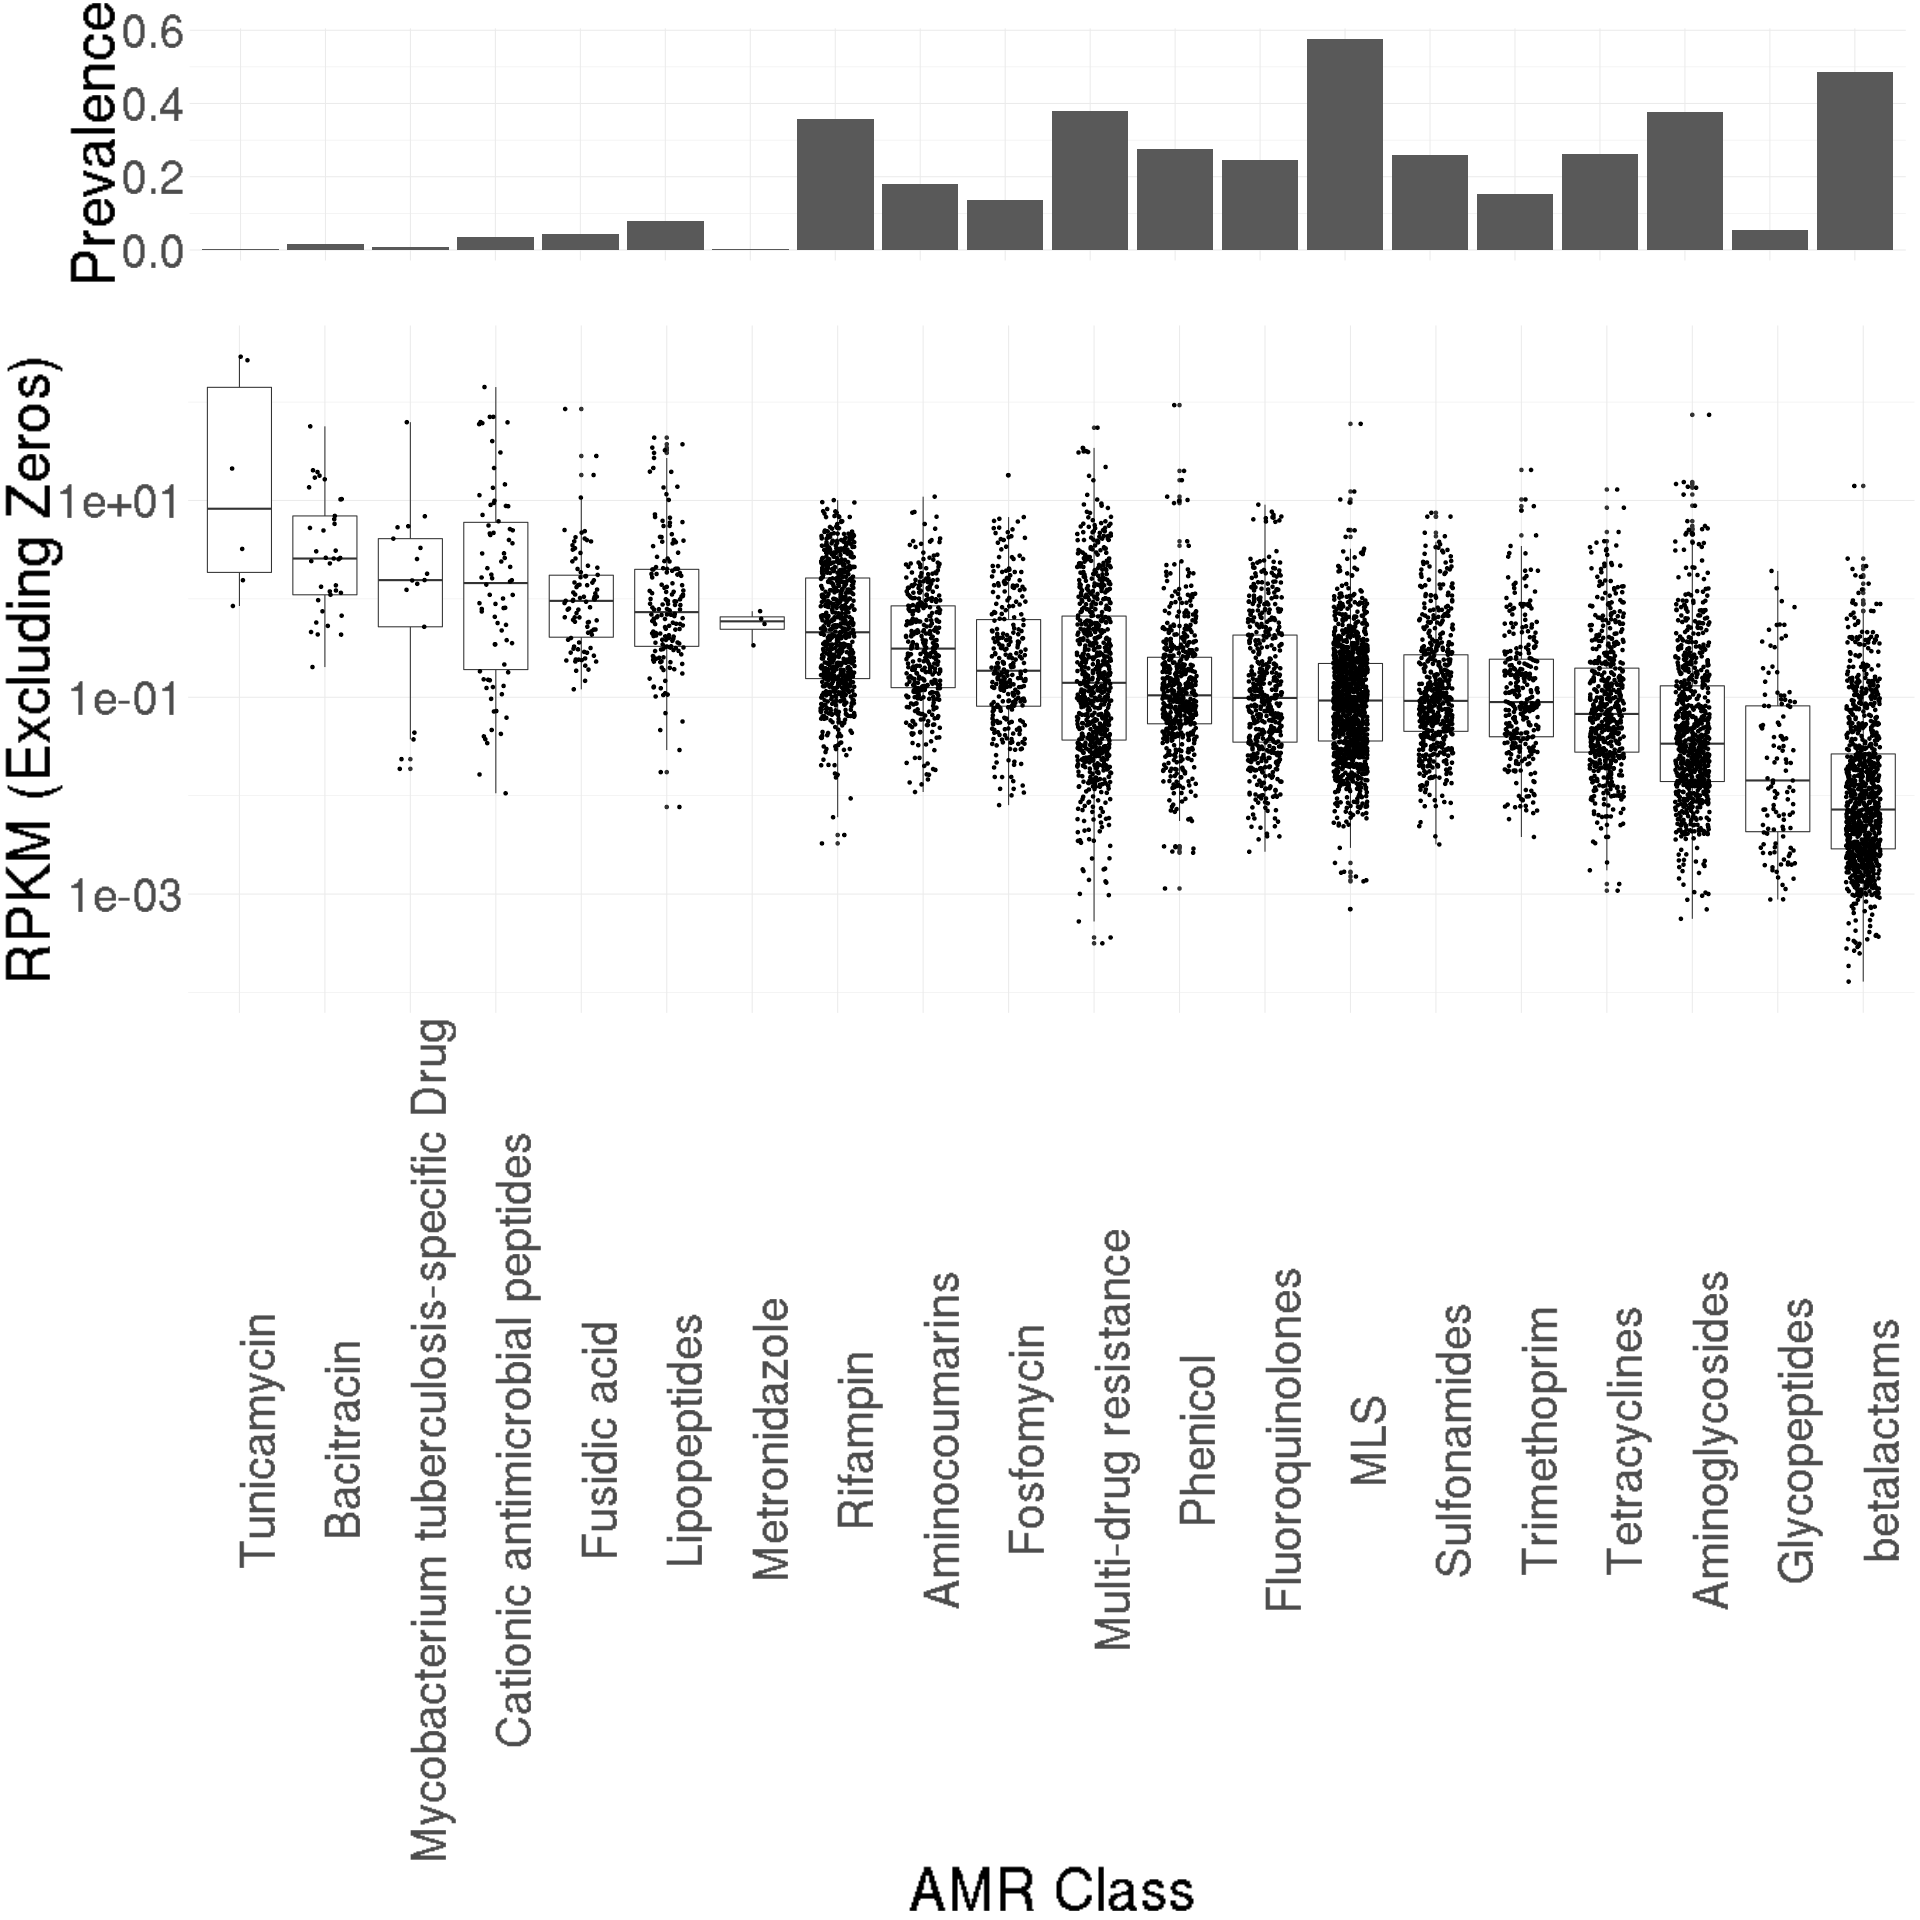

In [19]:
%%R -i amr_classes -i amr_order -i amr_count -w 1920 -h 1920

amr_classes$variable = ordered(amr_classes$variable, levels=amr_order)
amr_count$kind = ordered(amr_count$kind, levels=amr_order)
prev = ggplot(amr_count, aes(x=kind, y=prevalence)) +
    geom_col() +
    theme_minimal() +
    ylab('Prevalence') +
    theme(
        text = element_text(size=60),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        plot.margin = unit(c(1,0.5,2,2.5), "cm")
    )

dist = ggplot(amr_classes[amr_classes$value > 0,], aes(x=variable, y=value)) +
    geom_boxplot() +
    geom_jitter(width=0.2) +
    scale_y_log10() +
    theme_minimal() +
    ylab('RPKM (Excluding Zeros)') +
    xlab('AMR Class') +
    theme(
        text = element_text(size=60),
        axis.text.x= element_text(angle=90),
    )
    
grid.arrange(prev, dist, heights=c(1, 5))

In [21]:
amr_classes = core_tabler.amrs()
amr_classes = amr_classes.drop(columns='Elfamycins')
amr_order = list(amr_classes.apply(zero_drop_median).sort_values(ascending=False).index)
amr_count = pd.DataFrame((amr_classes > 0).mean())
amr_count['kind'] = amr_count.index
amr_count.columns = ['prevalence', 'kind']
amr_count


,prevalence,kind
Aminocoumarins,0.180490,Aminocoumarins
Aminoglycosides,0.376060,Aminoglycosides
Bacitracin,0.017436,Bacitracin
Cationic antimicrobial peptides,0.036758,Cationic antimicrobial peptides
Fluoroquinolones,0.244581,Fluoroquinolones
Fosfomycin,0.137606,Fosfomycin
Fusidic acid,0.042413,Fusidic acid
Glycopeptides,0.055608,Glycopeptides
Lipopeptides,0.079171,Lipopeptides
MLS,0.576343,MLS


In [22]:
amr_classes = core_tabler.amrs()
print(amr_classes.shape)
sum(amr_classes.sum(axis=1) > 0)

(2122, 21)


2122

## Supplementary

In [9]:
amr_gene = core_tabler.amrs(tool='megares', kind='gene')
print(amr_gene.shape)

amr_gene.head()

(2122, 1603)


,1002|AF140221.1|AF140221|Aminoglycosides|Aminoglycoside_N-acetyltransferases|AAC6-PRIME,1003|DQ267940.1|DQ267940|Trimethoprim|Dihydrofolate_reductase|DHFR|RequiresSNPConfirmation,1009|AF031326.1|AF031326|Aminoglycosides|Aminoglycoside_N-acetyltransferases|AAC6-PRIME,100|FR772051.1|FR772051|Aminoglycosides|Aminoglycoside_O-nucleotidyltransferases|ANT3-DPRIME,1019|JQ343850.1|JQ343850|Fosfomycin|Fosfomycin_thiol_transferases|FOSA,101|unknown_id|unknown_name|MLS|23S_rRNA_methyltransferases|ERMA,1021|AJ243209.1|AJ243209|MLS|Macrolide_resistance_efflux_pumps|MSRC,1034|JQ364968.1|JQ364968|betalactams|Class_A_betalactamases|CARB,1055|AY139601.1|AY139601|Phenicol|Chloramphenicol_acetyltransferases|CATB|RequiresSNPConfirmation,105|FR772051.1|FR772051|MLS|ABC_transporter|VGA,...,gi|81365634|gb|DQ105528.2|betalactams|Class_A_betalactamases|TEM,gi|81365639|gb|DQ105529.2|betalactams|Class_A_betalactamases|TEM,gi|817490718|gb|KP264123.1|betalactams|Class_D_betalactamases|OXA,gi|817490722|gb|KP264125.1|betalactams|Class_D_betalactamases|OXA,gi|82592678|gb|DQ279850.1|betalactams|Class_A_betalactamases|TEM,gi|83031782|gb|DQ286729.1|betalactams|Class_A_betalactamases|TEM,gi|84105058|gb|DQ322460.1|betalactams|Class_A_betalactamases|SHV,gi|86450761|gb|DQ369751.1|betalactams|Class_A_betalactamases|TEM,gi|89077561|gb|DQ388882.1|betalactams|Class_A_betalactamases|TEM,gi|94960154|gb|DQ519090.1|betalactams|Class_D_betalactamases|OXA
haib18CEM5453_HNHKFCCXY_SL346094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib17KIU4866_H7HJMCCXY_SL272751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib17CEM5106_HCV72CCXY_SL269764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib17CEM5241_HMGMHCCXY_SL343372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib18CEM5453_HMC2KCCXY_SL336614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
from scipy.cluster.hierarchy import linkage, cophenet, leaves_list
from scipy.spatial.distance import squareform, pdist
from math import log10

bamr = (amr_gene > 1).T

#amr_gene = amr_gene.apply(lambda s: s.apply(lambda x: log10(x + 1)))
distm = squareform(pdist(bamr, metric='jaccard'))
amr_jaccard = pd.DataFrame(distm, index=bamr.index, columns=bamr.index)

Z = linkage(squareform(amr_jaccard), 'average')
print(cophenet(Z, squareform(amr_jaccard))[0])
amr_order = amr_gene.columns[leaves_list(Z)]

amr_jaccard_long = amr_jaccard.copy()
amr_jaccard_long['amr'] = amr_jaccard_long.index
amr_jaccard_long = amr_jaccard_long.melt(id_vars=['amr'])
#amr_jaccard_long['value'] = amr_jaccard_long['value'].apply(lambda x: log10(x + 1))

amr_jaccard_long.head()

0.9381894603837067


,amr,variable,value
0,1034|JQ364968.1|JQ364968|betalactams|Class_A_b...,1034|JQ364968.1|JQ364968|betalactams|Class_A_b...,0.000000
1,1090|DQ303459.3|DQ303459|betalactams|Class_A_b...,1034|JQ364968.1|JQ364968|betalactams|Class_A_b...,0.969697
2,11|DQ679966.1|DQ679966|Multi-drug_resistance|M...,1034|JQ364968.1|JQ364968|betalactams|Class_A_b...,0.982036
3,1261|AY178993.1|AY178993|betalactams|Class_A_b...,1034|JQ364968.1|JQ364968|betalactams|Class_A_b...,0.536585
4,1268|AB976602.1|AB976602|betalactams|Class_A_b...,1034|JQ364968.1|JQ364968|betalactams|Class_A_b...,0.968109


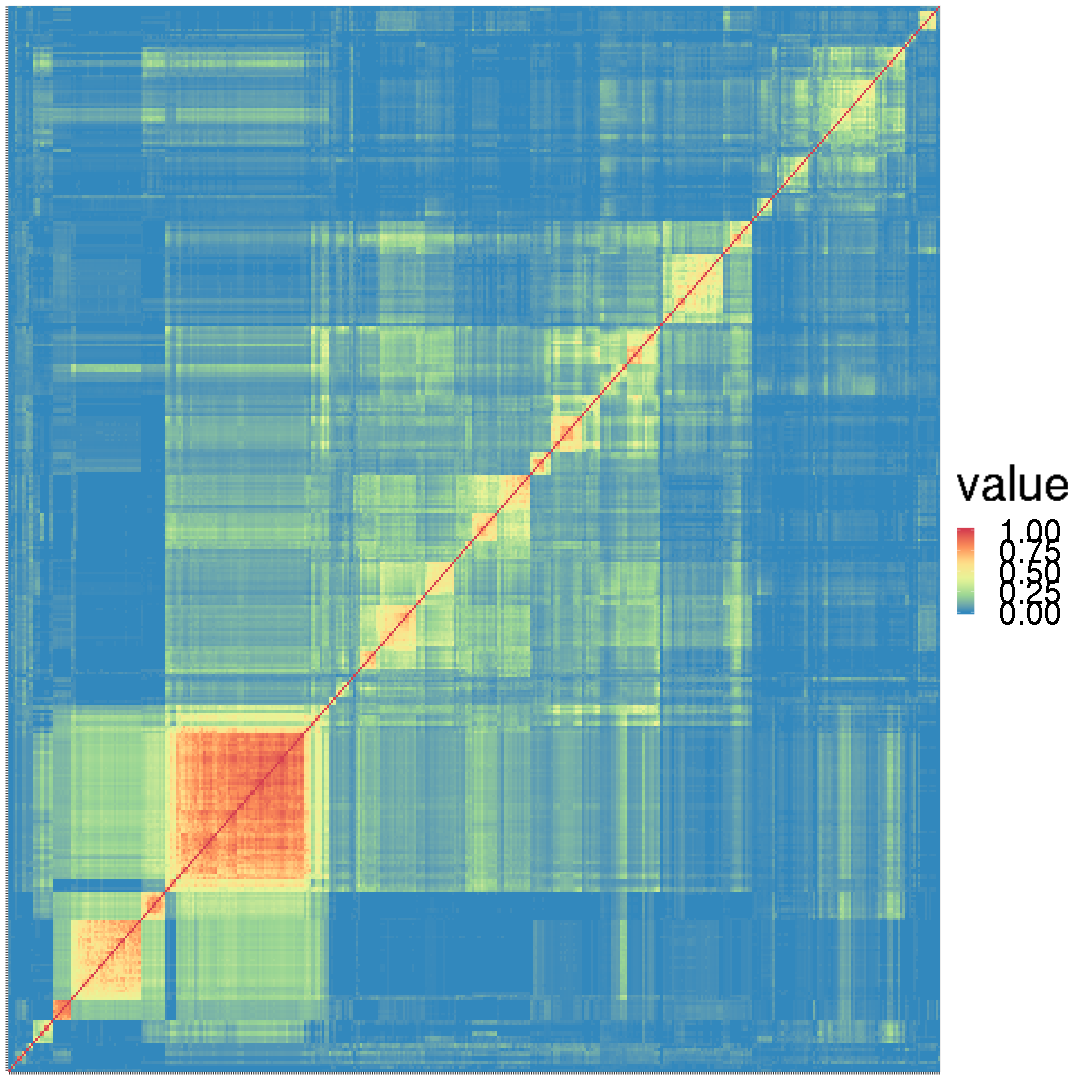

In [12]:
%%R -i amr_jaccard_long -i amr_order -w 1080 -h 1080

amr_jaccard_long$amr = ordered(
    amr_jaccard_long$amr,
    levels=amr_order
)
amr_jaccard_long$variable = ordered(
    amr_jaccard_long$variable,
    levels=amr_order
)
amr_jaccard_long$value = 1 - amr_jaccard_long$value

ggplot(amr_jaccard_long, aes(x=amr, y=variable, fill=value)) +
    geom_tile() +
    scale_fill_distiller(palette='Spectral', direction=-1) +
    theme(
        text = element_text(size=50),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='right',
        axis.text.x=element_blank(),
        axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.title.y=element_blank(),
    )

In [13]:
foo = pd.Series(amr_gene.columns).apply(lambda x: pd.Series([x] + x.split('|')))
foo = foo[range(7)]
foo.columns = ['amr', 'code', 'id', 'name', 'classus', 'mech', 'group']
foo = foo.set_index('amr')
foo['amr'] = foo.index
foo = foo.drop(columns=['code', 'id', 'name'])
foo.head()

def has_number(el):
    for i in range(10):
        if str(i) in el:
            return True
    if '.'  in el:
        return True
    if '-' in el and 'Multi-' not in el:
        return True
    return False


AMR_CLASSES = set(core_tabler.amrs().columns)
def get_amr_class(el):
    for amr_class in AMR_CLASSES:
        if amr_class in el:
            return amr_class
    return 'unknown'

tbl = {}
for amr, rec in foo.iterrows():
    tbl[amr] = {get_amr_class(amr): 1}
tbl = pd.DataFrame.from_dict(tbl, orient='index').fillna(0)
tbl['amr'] = tbl.index
tbl = tbl.melt(id_vars='amr')
tbl.head()

,amr,variable,value
0,1034|JQ364968.1|JQ364968|betalactams|Class_A_b...,betalactams,1.0
1,1090|DQ303459.3|DQ303459|betalactams|Class_A_b...,betalactams,1.0
2,11|DQ679966.1|DQ679966|Multi-drug_resistance|M...,betalactams,0.0
3,1261|AY178993.1|AY178993|betalactams|Class_A_b...,betalactams,1.0
4,1268|AB976602.1|AB976602|betalactams|Class_A_b...,betalactams,1.0


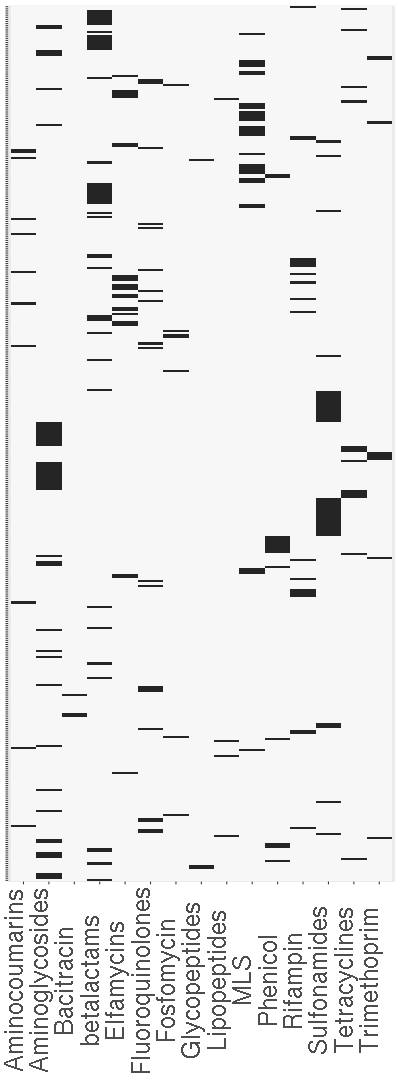

In [14]:
%%R -i tbl -i amr_order  -h 1080 -w 400

tbl$amr = ordered(
    tbl$amr,
    levels=amr_order
)


ggplot(tbl[tbl$variable != 'unknown',], aes(x=variable, y=amr, fill=value)) +
    geom_tile() +
    scale_fill_distiller(palette='Greys', direction=1) +
    theme(
        text = element_text(size=30),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='none',
        axis.text.x=element_text(angle=90, vjust=-0.05),
        axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.title.y=element_blank(),
        axis.ticks.y=element_blnk(),
    )


In [15]:
amr_homology = pd.read_csv('/home/dcdanko/Dropbox/megares_gene_gene_homology.csv', index_col=0)
amr_homology.loc[amr_homology.index.isin(amr_order), amr_homology.columns.isin(amr_order)]
amr_homology['amr'] = amr_homology.index
amr_homology_long = amr_homology.melt(id_vars='amr')
amr_homology_long = amr_homology_long.dropna()
amr_homology_long.head()

,amr,variable,value
24,1114|EU670845.2|EU670845|betalactams|Class_D_b...,Bla|OXA-223|JN248564|1-825|825|betalactams|Cla...,97.82
67,1260|DQ519086.1|DQ519086|betalactams|Class_D_b...,Bla|OXA-223|JN248564|1-825|825|betalactams|Cla...,98.55
91,1329|EF653400.1|EF653400|betalactams|Class_D_b...,Bla|OXA-223|JN248564|1-825|825|betalactams|Cla...,98.67
1020,Bla|KF057032.1|gene1|betalactams|Class_D_betal...,Bla|OXA-223|JN248564|1-825|825|betalactams|Cla...,97.82
1021,Bla|KF057034.1|gene1|betalactams|Class_D_betal...,Bla|OXA-223|JN248564|1-825|825|betalactams|Cla...,98.30


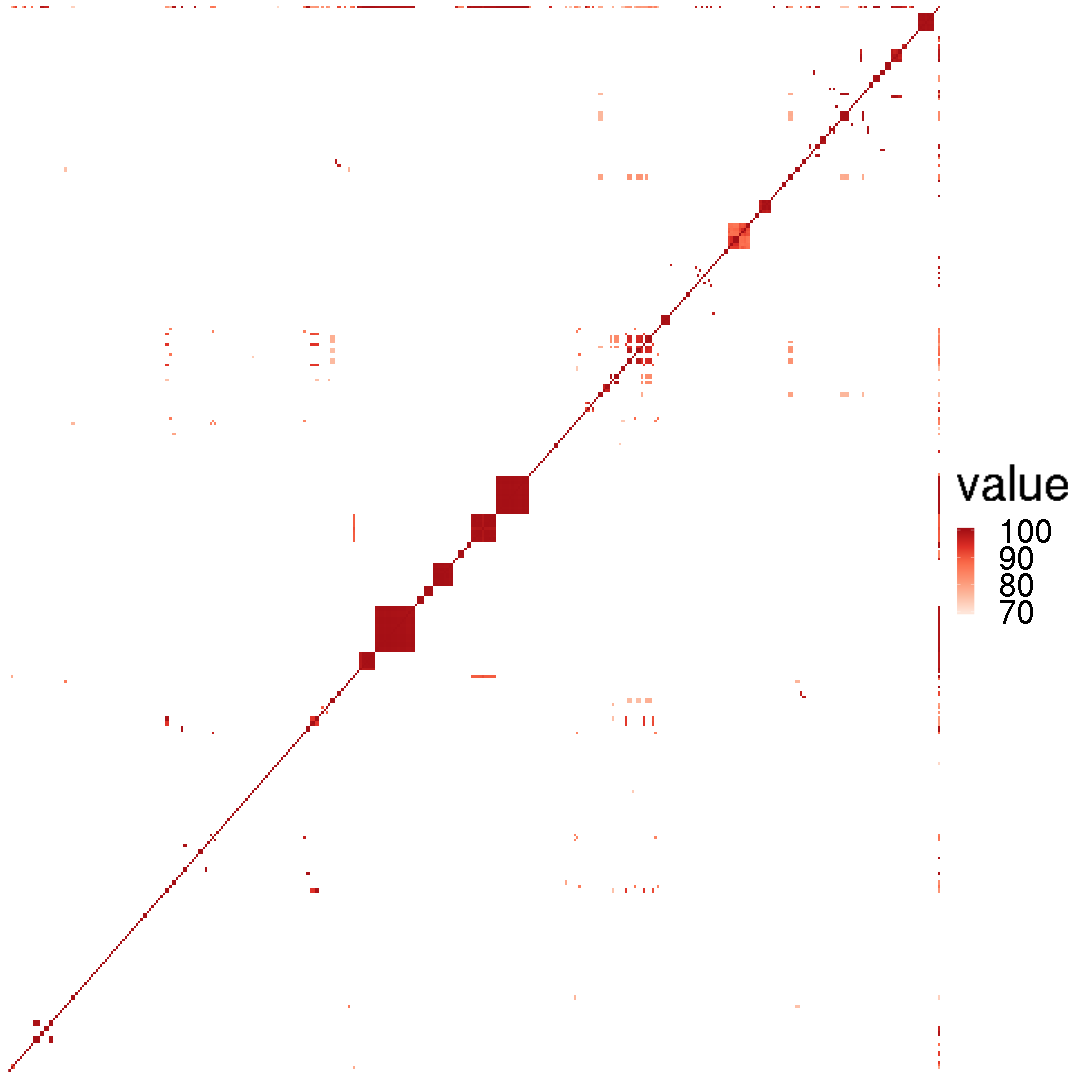

In [16]:
%%R -i amr_homology_long -i amr_order -w 1080 -h 1080

amr_homology_long$amr = ordered(
    amr_homology_long$amr,
    levels=amr_order
)
amr_homology_long$variable = ordered(
    amr_homology_long$variable,
    levels=amr_order
)

ggplot(amr_homology_long, aes(x=amr, y=variable, fill=value)) +
    geom_tile() +
    scale_fill_distiller(palette='Reds', direction=1) +
    theme_minimal() +
    theme(
        text = element_text(size=50),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='right',
        axis.text.x=element_blank(),
        axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.title.y=element_blank(),
    )

In [18]:

amr_gene = core_tabler.amrs(kind='gene')
amr_gene = amr_gene.apply(lambda s: s.apply(lambda v: int(v) + 1))
print(amr_gene.shape)

design = core_tabler.metadata.loc[amr_gene.index, ['continent', 'surface_ontology_fine', 'city_koppen_climate', 'city_population_density', 'city_ave_june_temp_c', 'coastal_city', 'city_elevation_meters']].fillna('unknown')
design['continent'] = [str(el) for el in design['continent']]
design['surface_ontology_fine'] = [str(el) for el in design['surface_ontology_fine']]
design = design.query('continent != "0"')  #.query('city_population_density > 0')
amr_gene = amr_gene.loc[design.index]

print(amr_gene.shape)
print(design.shape)
design.head()

(2122, 1603)
(2122, 1603)
(2122, 7)


,continent,surface_ontology_fine,city_koppen_climate,city_population_density,city_ave_june_temp_c,coastal_city,city_elevation_meters
haib18CEM5453_HNHKFCCXY_SL346094,east_asia,unknown,humid_subtropical_climate,6777,30.3,yes,957
haib17KIU4866_H7HJMCCXY_SL272751,sub_saharan_africa,unknown,tropical_savanna_climate,1188,25.6,no,310
haib17CEM5106_HCV72CCXY_SL269764,north_america,unknown,humid_subtropical_climate,11000,23.3,yes,10
haib17CEM5241_HMGMHCCXY_SL343372,east_asia,metal,tropical_rainforest_climate,7796,29.2,yes,163.63
haib18CEM5453_HMC2KCCXY_SL336614,east_asia,unknown,humid_subtropical_climate,6777,30.3,yes,957


In [19]:
%%R -i amr_gene -i design

devtools::load_all('/home/dcdanko/Dev/mavric/')

mav = estVC(as.matrix(t(amr_gene)), design, clist, verbose=T, autosel=F, sigcor=F)

[1] "Confirmed inputs"
[1] "running HTS"
[1] "Built PCA Obj"
[1] "Finding relevant PCs"
Error in { : 
  task 4 failed - "y is constant; gaussian glmnet fails at standardization step"


In [20]:
%%R
        
design$continent = as.factor(design$continent)
design$surface_ontology_fine = as.factor(design$surface_ontology_fine)
design$coastal_city = as.factor(design$coastal_city)

plotVars(mav, design, plotve=F)


Error in lapply(results$pcs, function(e) e[as.numeric(rownames(e)) > 0,  : 
  object 'mav' not found


In [52]:
from sklearn.decomposition import PCA


taxa = core_tabler.amrs(kind='gene')

NPCS=100
pca = PCA(n_components=NPCS)
pcs = pca.fit_transform(taxa)
pcs = pd.DataFrame(data=pcs, index=taxa.index, columns=[f'PC{i}' for i in range(NPCS)])

pcs['surface'] = core_tabler.metadata['surface_ontology_fine']
pcs['surface'] = [str(el) for el in pcs['surface']]

pcs['temperature'] = core_tabler.metadata['city_ave_june_temp_c']
pcs['pop_density'] = core_tabler.metadata['city_population_density']

pcs['continent'] = core_tabler.metadata['continent']
pcs['continent'] = [str(el) for el in pcs['continent']]

pcs['sample'] = [str(el) for el in pcs.index]
pcs = pcs.loc[pcs['surface'] != 'nan']
pcs = pcs.loc[pcs['surface'] != 'control']
pcs = pcs.loc[pcs['continent'] != '0']
foo = pcs.melt(id_vars=['surface', 'sample', 'temperature', 'pop_density', 'continent'])
print(foo.shape)
foo.head()

(125300, 7)


,surface,sample,temperature,pop_density,continent,variable,value
0,plastic,haib17CEM5241_HMGMHCCXY_SL343357,29.2,7796.0,east_asia,PC0,-9.819167
1,metal,haib17CEM5106_HCCGHCCXY_SL270293,14.4,5590.0,europe,PC0,-9.951201
2,plastic,haib17CEM5241_HMGMHCCXY_SL343440,23.9,3299.0,europe,PC0,-9.815616
3,metal,haib17CEM5106_HCCGHCCXY_SL270220,14.4,5590.0,europe,PC0,-9.874778
4,metal,haib17CEM5241_HMGMHCCXY_SL343376,29.2,7796.0,east_asia,PC0,-9.827400


In [53]:
from math import log2
from scipy.stats import gmean

def sign(val):
    return 1 if val >= 0 else 0

def outlier_cropping_mean(s):
    low, high = s.quantile(0.1), s.quantile(0.99)
    s = s[s > low]
    s = s[s < high]
    return s.mean()

def scaleit(tbl):
    tbl = tbl.groupby('surface').mean()
    return tbl
    


bar = foo.groupby('variable').apply(scaleit)
bar['variable'] = [str(el[0]) for el in bar.index]
bar['surface'] = [str(el[1]) for el in bar.index]
bar.head()

temperature  pop_density      value variable     surface
variable surface                                                             
PC0      biological    21.885795  4006.602273  22.167225      PC0  biological
         fabric        24.366667  1471.833333 -47.723183      PC0      fabric
         metal         23.051268  6254.969292  -3.056495      PC0       metal
         plastic       24.760870  4600.462451  12.236297      PC0     plastic
         stone         27.153623  5834.666667  -9.642017      PC0       stone

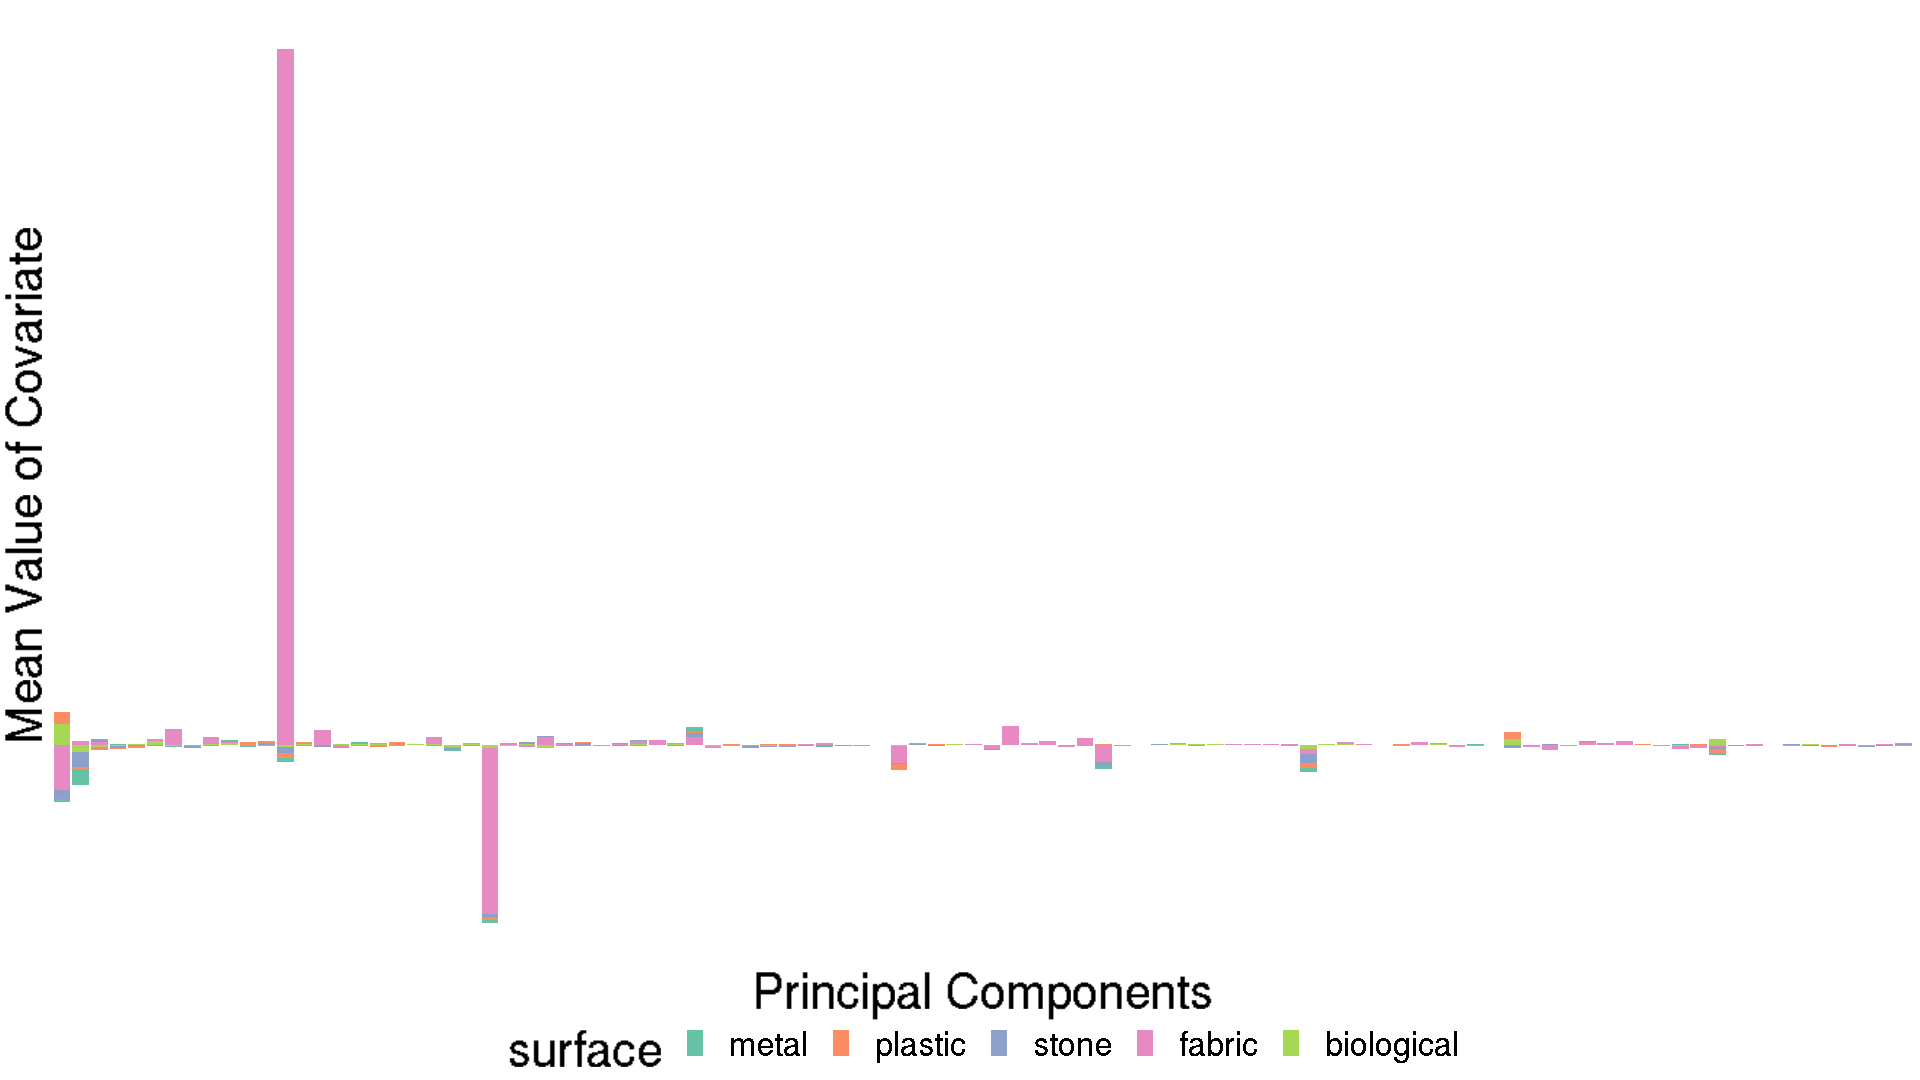

In [54]:
%%R -i bar -w 1920 -h 1080

bar$surface = ordered(bar$surface, levels=c('metal', 'plastic', 'stone', 'fabric', 'biological'))
ggplot(bar, aes(x=variable, y=value, fill=surface)) +
    geom_bar(stat='identity') +
    theme_minimal() +
    scale_fill_brewer(palette='Set2') +
    #scale_y_continuous(trans=reverselog_trans(base=2), labels=trans_format("identity", function(x) -x)) +
    xlab('Principal Components') +
    ylab('Mean Value of Covariate') +
    theme(
        text = element_text(size=50),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='bottom',
        axis.text.x=element_blank(),
        #axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        #axis.title.y=element_blank(),
    )

In [55]:
from math import log2

def sign(val):
    return 1 if val >= 0 else 0

def scaleit(tbl):
    return tbl.groupby('continent').mean()
    


bar = foo.groupby('variable').apply(scaleit)
bar['variable'] = [str(el[0]) for el in bar.index]
bar['continent'] = [str(el[1]) for el in bar.index]
bar.head()

temperature   pop_density       value variable  \
variable continent                                                       
PC0      east_asia        28.488317   6736.619802   -3.668855      PC0   
         europe           17.102279   5363.792023   -2.394164      PC0   
         middle_east      37.500000  10000.000000   -7.674498      PC0   
         north_america    23.146154   6925.811189   15.260614      PC0   
         oceania          11.383333   1274.666667  400.999628      PC0   

                            continent  
variable continent                     
PC0      east_asia          east_asia  
         europe                europe  
         middle_east      middle_east  
         north_america  north_america  
         oceania              oceania

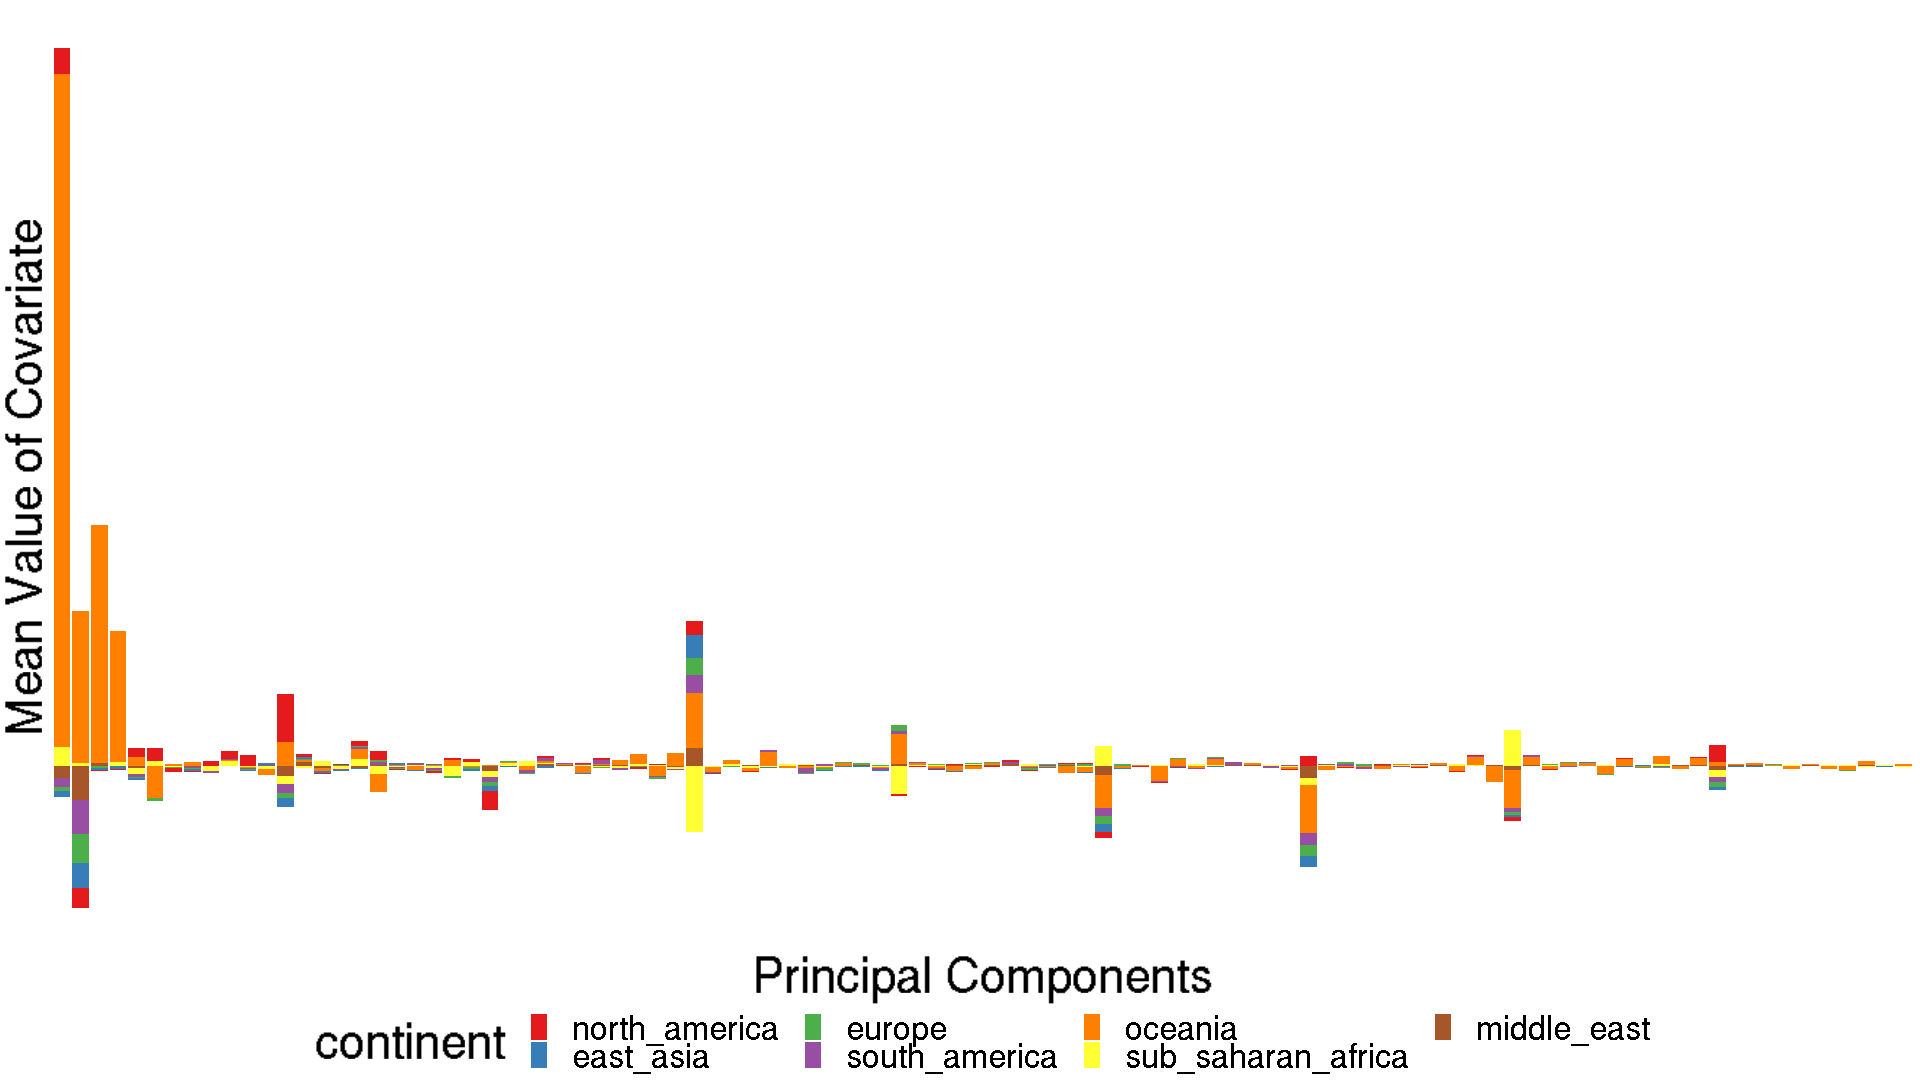

In [56]:
%%R -i bar -w 1920 -h 1080

bar$continent = ordered(
    bar$continent,
    levels=c(
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
)
)
ggplot(bar, aes(x=variable, y=value, fill=continent)) +
    geom_bar(stat='identity') +
    theme_minimal() +
    scale_fill_brewer(palette='Set1') +
    #scale_y_continuous(trans=reverselog_trans(base=2), labels=trans_format("identity", function(x) -x)) +
    xlab('Principal Components') +
    ylab('Mean Value of Covariate') +
    theme(
        text = element_text(size=50),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='bottom',
        axis.text.x=element_blank(),
        #axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        #axis.title.y=element_blank(),
    )

In [59]:
pca.explained_variance_ratio_

array([1.97015467e-01, 1.95705100e-01, 1.65396918e-01, 9.00784342e-02,
       3.34405610e-02, 3.23425519e-02, 2.76613738e-02, 2.57426620e-02,
       2.26739547e-02, 2.14263253e-02, 1.74391326e-02, 1.34547988e-02,
       1.27880338e-02, 1.26846595e-02, 1.23286479e-02, 1.06578376e-02,
       8.24137324e-03, 7.96891691e-03, 7.07187069e-03, 6.35475361e-03,
       5.66017047e-03, 5.46869412e-03, 4.77364443e-03, 3.69071095e-03,
       3.22198361e-03, 2.92221374e-03, 2.82712991e-03, 2.40463193e-03,
       2.37801014e-03, 2.14300632e-03, 1.74077438e-03, 1.67915648e-03,
       1.61255172e-03, 1.40761126e-03, 1.36136909e-03, 1.33458869e-03,
       1.23202477e-03, 1.19328626e-03, 1.12805395e-03, 1.10254435e-03,
       1.05453380e-03, 9.66679755e-04, 9.33640859e-04, 9.08823736e-04,
       8.91448596e-04, 7.75806712e-04, 7.31764965e-04, 6.98311951e-04,
       6.85013921e-04, 6.64847525e-04, 6.54773976e-04, 6.47973366e-04,
       6.19383734e-04, 5.77969374e-04, 5.46380219e-04, 5.28626179e-04,
      

In [60]:
from math import sin, cos, sqrt, atan2
from scipy.spatial.distance import squareform, pdist
from itertools import combinations


def gdist(r1, r2):
    R = 6373.0
    dlon, lon2, lon1 = r2[1] - r1[1], r2[1], r1[1]
    dlat, lat2, lat1 = r2[0] - r1[0], r2[0], r1[0]
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

def geodists(samples):
    """Small so just use euclidean distance"""
    coords = core_tabler.metadata.loc[samples, ['latitude', 'longitude']]
    coords = coords.dropna()
    coords = coords.query('abs(latitude) > 0')
    gdists = pd.DataFrame(squareform(pdist(coords, gdist)), columns=coords.index, index=coords.index)
    return gdists
    
def elongate(city, jsd, geo):
    tbl = {}
    for s1, s2 in combinations(jsd.index, 2):
        j = jsd.loc[s1, s2]
        g = geo.loc[s1, s2]
        tbl[(city, s1, s2)] = {'jsd': j, 'geo': g, 'city': city}
    return pd.DataFrame.from_dict(tbl, orient='index')

In [70]:
amr_gene = core_tabler.amrs(kind='gene')
bamr = (amr_gene > 1)

distm = squareform(pdist(bamr, metric='jaccard'))
amr_jaccard = pd.DataFrame(distm, index=bamr.index, columns=bamr.index)
amr_jaccard

,haib18CEM5453_HMC2KCCXY_SL336779,haib17CEM4890_H75CGCCXY_SL263712,haib17CEM5241_HMGMHCCXY_SL343357,haib17DB4959_HMGW3CCXY_SL342489,haib17CEM5106_HCCGHCCXY_SL270293,haib17CEM5241_HMGMHCCXY_SL343440,haib17DB4959_HMGW3CCXY_SL342492,haib18CEM5453_HNGH3CCXY_SL344548,haib17CEM5106_HCCGHCCXY_SL270220,haib17CEM5241_HMGMHCCXY_SL343376,...,haib17CEM4890_HKC32ALXX_SL254765,haib18CEM5453_HMC2KCCXY_SL336829,haib18CEM5453_HMC2KCCXY_SL336821,haib17CEM4890_HMCMJCCXY_SL335799,haib17CEM5106_HCY5HCCXY_SL271171,haib17CEM4890_H7KYMCCXY_SL273062,haib17KIU4866_H7HJMCCXY_SL272752,haib18CEM5453_HT5YVCCXY_SL357265,haib18CEM5453_HT5YVCCXY_SL357395,haib17CEM5106_HCCGHCCXY_SL270450
haib18CEM5453_HMC2KCCXY_SL336779,0.000000,1.000000,0.800000,1.000000,1.000000,1.0,1.000000,0.944444,0.875000,0.833333,...,1.000000,1.000000,0.375000,0.782609,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
haib17CEM4890_H75CGCCXY_SL263712,1.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.950000,1.000000,1.000000,...,0.785714,1.000000,1.000000,1.000000,1.000000,1.000000,0.893939,1.0,1.000000,1.000000
haib17CEM5241_HMGMHCCXY_SL343357,0.800000,1.000000,0.000000,1.000000,1.000000,1.0,1.000000,0.928571,1.000000,1.000000,...,1.000000,1.000000,0.875000,0.956522,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
haib17DB4959_HMGW3CCXY_SL342489,1.000000,1.000000,1.000000,0.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.666667,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
haib17CEM5106_HCCGHCCXY_SL270293,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,0.833333,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.714286
haib17CEM5241_HMGMHCCXY_SL343440,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
haib17DB4959_HMGW3CCXY_SL342492,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.888889,0.958333,1.000000,1.000000,1.000000,1.0,1.000000,0.944444
haib18CEM5453_HNGH3CCXY_SL344548,0.944444,0.950000,0.928571,1.000000,1.000000,1.0,1.000000,0.000000,1.000000,1.000000,...,0.975000,0.937500,0.952381,0.806452,1.000000,1.000000,0.888889,1.0,0.928571,1.000000
haib17CEM5106_HCCGHCCXY_SL270220,0.875000,1.000000,1.000000,1.000000,0.833333,1.0,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,0.909091,0.961538,1.000000,1.000000,1.000000,1.0,1.000000,0.833333
haib17CEM5241_HMGMHCCXY_SL343376,0.833333,1.000000,1.000000,0.666667,1.000000,1.0,1.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.888889,0.958333,1.000000,1.000000,1.000000,1.0,1.000000,1.000000


In [80]:
taxa_jsd = amr_jaccard

all_dist_samples = set(taxa_jsd.index) & set(core_tabler.metadata.query('abs(latitude) > 0').index)
tbls = []
for city in core_tabler.metadata['city'].unique():
    samples = core_tabler.metadata.query(f'city == "{city}"').index
    samples = set(samples) & all_dist_samples
    if len(samples) == 0:
        continue
    city_taxa_dists = taxa_jsd.loc[samples, samples]
    city_geo_dists = geodists(samples)
    tbls.append(elongate(city, city_taxa_dists, city_geo_dists))

dist_pairs = pd.concat(tbls)
dist_pairs = dist_pairs.query('geo < 50').query('geo > 1')
dist_pairs.head()

jsd  \
berlin haib17CEM4890_H7KYMCCXY_SL273042 haib17CEM4890_H7KYMCCXY_SL273125  0.800000   
       haib17CEM4890_H7KYMCCXY_SL273066 haib17CEM4890_H7KYMCCXY_SL273042  0.833333   
                                        haib17CEM4890_H7KYMCCXY_SL273113  0.625000   
                                        haib17CEM4890_H7KYMCCXY_SL273125  0.428571   
       haib17CEM4890_H7KYMCCXY_SL273113 haib17CEM4890_H7KYMCCXY_SL273042  0.937500   

                                                                                geo  \
berlin haib17CEM4890_H7KYMCCXY_SL273042 haib17CEM4890_H7KYMCCXY_SL273125  35.703951   
       haib17CEM4890_H7KYMCCXY_SL273066 haib17CEM4890_H7KYMCCXY_SL273042  28.549555   
                                        haib17CEM4890_H7KYMCCXY_SL273113   9.502668   
                                        haib17CEM4890_H7KYMCCXY_SL273125   9.502668   
       haib17CEM4890_H7KYMCCXY_SL273113 haib17CEM4890_H7KYMCCXY_SL273042  35.703951   

                                                                            city  
berlin haib17CEM4890_H7KYMCCXY_SL273042 haib17CEM4890_H7KYMCCXY_SL273125  berlin  
       haib17CEM4890_H7KYMCCXY_SL273066 haib17CEM4890_H7KYMCCXY_SL273042  berlin  
                                        haib17CEM4890_H7KYMCCXY_SL273113  berlin  
                                        haib17CEM4890_H7KYMCCXY_SL273125  berlin  
       haib17CEM4890_H7KYMCCXY_SL273113 haib17CEM4890_H7KYMCCXY_SL273042  berlin

In [81]:
dist_pairs['city'].value_counts()

hong_kong        6765
ilorin           6253
singapore         735
london            651
tokyo             505
new_york_city     163
offa              140
doha              103
taipei             44
sao_paulo          40
santiago           23
vienna             16
sendai             12
kuala_lumpur       11
naples              9
bogota              6
seoul               6
berlin              5
baltimore           5
sofia               2
paris               2
minneapolis         1
brisbane            1
san_francisco       1
Name: city, dtype: int64

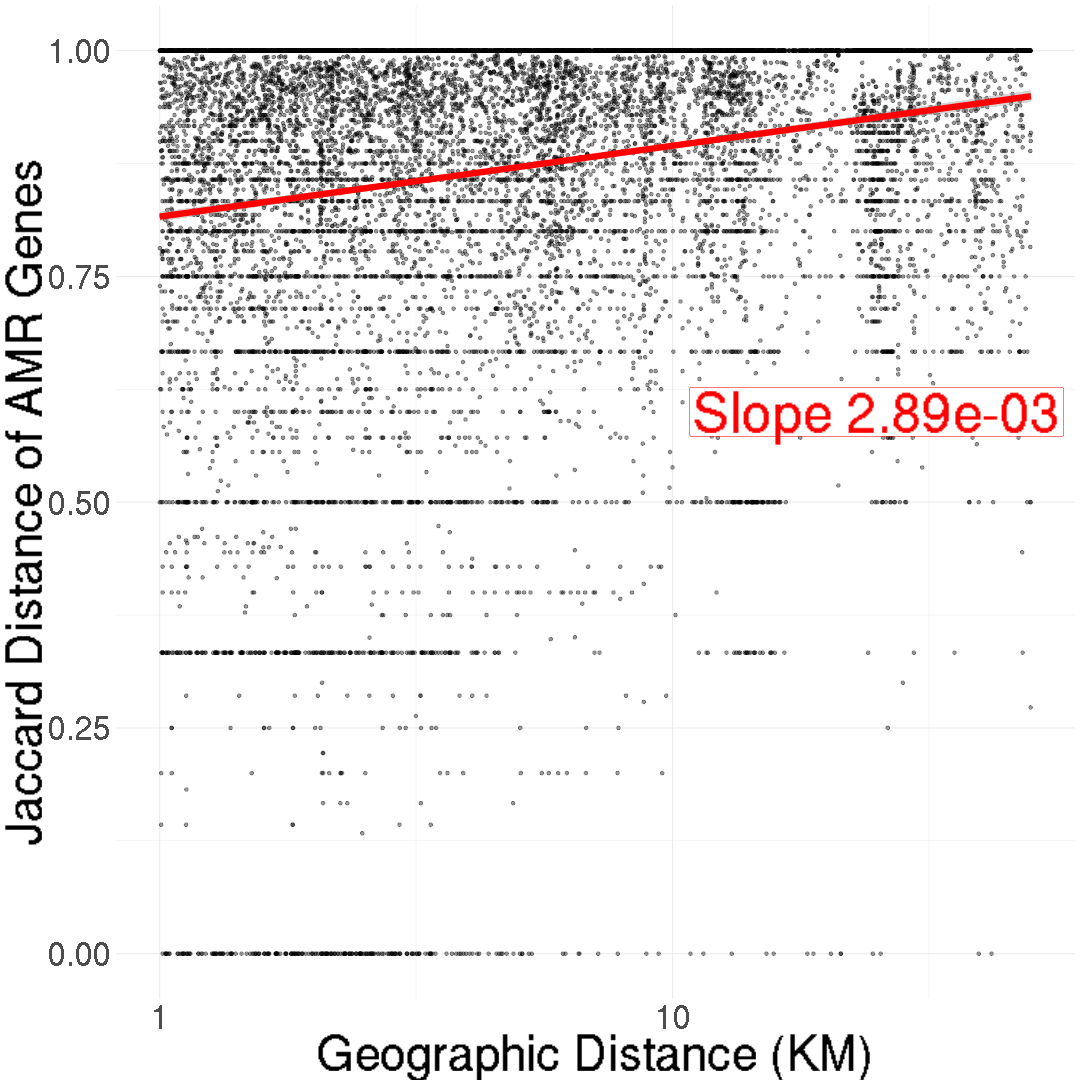

In [85]:
%%R  -i dist_pairs -w 1080 -h 1080

ann_text = data.frame(
    geo=25,
    jsd=0.6
)

ggplot(dist_pairs, aes(y=jsd, x=geo)) +
    geom_point(alpha=0.4) +
    #geom_density_2d(size=1, color='blue') +
    scale_x_log10() +
    #scale_y_log10() +
    geom_smooth(method='lm', color='red', size=3) +
    ylab('Jaccard Distance of AMR Genes') +
    xlab('Geographic Distance (KM)') +
    theme_minimal() +
    geom_label(data=ann_text, label="Slope 2.89e-03", size=20, color='red') +
    theme(
        text = element_text(size=50),
    )

In [83]:
%%R

fit = lm(jsd ~ geo, data=dist_pairs)
summary(fit)



Call:
lm(formula = jsd ~ geo, data = dist_pairs)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.96568 -0.05047  0.06051  0.12703  0.15252 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.8445864  0.0019934  423.69   <2e-16 ***
geo         0.0028913  0.0001293   22.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1881 on 15497 degrees of freedom
Multiple R-squared:  0.03127,	Adjusted R-squared:  0.03121 
F-statistic: 500.3 on 1 and 15497 DF,  p-value: < 2.2e-16

